Load + clean > Jianing
create spine (target) > Alejandro
train/test split > (--)
baseline_calculation(train) > Alvaro
baseline_predict(test): [parcela, tstamp, target, y_pred] > Alvaro
evaluation > Alvaro


y =[0, 1, 3, 1, 1, 0...]
estado = [12, 7, 3, 13, 11, ...]
baseline_mapping = train.groupby(estado)[target_col].mean().to_dict()
test[y_pred] = test[estado].map(baseline_mapping)

In [55]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score

In [56]:
root_folder = "/Users/alvaroleal/Desktop/DS/komorebi"

df = pd.read_parquet(root_folder + '/muestreos_parcelas.parquet')

## Limpiamos los datos con los resultados del EDAs

In [57]:
def clean_df(df):
    """
    Función para realizar todo el lipiado de datos, en este momento elimina las filas del DataFrame donde el año es 2005, 2021 o 2022.

    Args:
    df (pd.DataFrame): DataFrame original.

    Returns:
    pd.DataFrame: DataFrame limpiado.
    """
    # Añadir los resultados del EDAs
    df = df.drop('generated_muestreos', axis=1)  
    cols = ['fecha'] + [col for col in df.columns if col != 'fecha']
    df = df[cols]
    df['fecha'] = df['fecha'].astype('datetime64[ns]')
    df = df[~df['fecha'].dt.year.isin([2003, 2005, 2021, 2022])]
    
    return df

In [58]:
df = clean_df(df)

## Baseline: 
- Simplificamos nuestro dataset reduciéndolo a tres columnas.
- Calculamos los estados fenológicos que han avanzado cada instancia de cada parcela por año.
- Calculamos la media para cada estado y creamos nuestro target.

In [59]:
columnas_estados = [f'estado_fenologico_{i}' for i in range(14, 0, -1)]

df['estado_fenologico_unificado'] = df.apply(lambda row: next((col.split('_')[-1] for col in columnas_estados if row[col] == 2), pd.NA), axis=1)
df['estado_fenologico_unificado'] = pd.to_numeric(df['estado_fenologico_unificado'])

df = df[['codparcela','fecha','estado_fenologico_unificado']]

In [60]:
df = df.copy()

df.sort_values(by=['codparcela', 'fecha'], inplace=True)

df['year'] = df['fecha'].dt.year

df['y'] = df.groupby(['codparcela', 'year'], observed=True)['estado_fenologico_unificado'].shift(-1) - df['estado_fenologico_unificado']

first_last_mask = (df['fecha'] == df.groupby(['codparcela', 'year'], observed=True)['fecha'].transform('first')) | \
                  (df['fecha'] == df.groupby(['codparcela', 'year'], observed=True)['fecha'].transform('last'))

df.loc[first_last_mask, 'y'] = np.nan

df.head(12)

,codparcela,fecha,estado_fenologico_unificado,year,y
3960,000-00000-00,2015-08-25,10.0,2015,NaN
3961,000-00000-00,2015-09-30,11.0,2015,NaN
16815,000-00000-00-0,2015-08-24,10.0,2015,NaN
7323,000-00000-00-0,2015-08-26,10.0,2015,1.0
16816,000-00000-00-0,2015-09-28,11.0,2015,0.0
7324,000-00000-00-0,2015-09-29,11.0,2015,NaN
131748,000-00900-00-U0,2006-04-24,2.0,2006,NaN
131749,000-00900-00-U0,2006-05-03,2.0,2006,1.0
131750,000-00900-00-U0,2006-05-08,3.0,2006,1.0
131751,000-00900-00-U0,2006-05-16,4.0,2006,3.0


### Ejemplo muy sencillo de la creación, entrenamiento y evaluación de un baseline

In [61]:
# Dividimos nuestras muestras por años
train = df[df['year'] <= 2018].copy()
test = df[df['year'] > 2018].copy()

In [62]:
# Calcular el mapeo de referencia basado en el estado fenológico actual y la progresión media al siguiente estado
mapeo_referencia = train.groupby('estado_fenologico_unificado')['y'].mean().to_dict()

# Aplicar el mapeo de referencia al conjunto de test para obtener las predicciones
test.loc[:, 'y_pred'] = test['estado_fenologico_unificado'].map(mapeo_referencia)

# Dado que la métrica de precisión requiere valores discretos, redondearemos los valores predichos
test.loc[:, 'y_pred_rounded'] = test['y_pred'].round()

In [64]:
# Eliminar filas con NaN en 'y' antes de calcular la precisión.
mask = test['y'].notna()
test_filtered = test[mask]

# Ahora, calcular la precisión solo en las filas sin NaN.
accuracy = accuracy_score(test_filtered['y'], test_filtered['y_pred_rounded'])
print(f"Baseline Model Accuracy: {accuracy}")

Baseline Model Accuracy: 0.7508221392341564


In [68]:
test_filtered.head(50)

,codparcela,fecha,estado_fenologico_unificado,year,y,y_pred,y_pred_rounded
497621,001-00001-01,2019-03-19,2.0,2019,0.0,0.497378,0.0
497622,001-00001-01,2019-03-26,2.0,2019,0.0,0.497378,0.0
497623,001-00001-01,2019-04-02,2.0,2019,3.0,0.497378,0.0
497624,001-00001-01,2019-04-22,5.0,2019,1.0,0.943173,1.0
497625,001-00001-01,2019-04-30,6.0,2019,0.0,0.899980,1.0
497626,001-00001-01,2019-05-07,6.0,2019,1.0,0.899980,1.0
497627,001-00001-01,2019-05-15,7.0,2019,1.0,0.918746,1.0
497628,001-00001-01,2019-05-21,8.0,2019,1.0,0.743699,1.0
497629,001-00001-01,2019-05-28,9.0,2019,0.0,0.209981,0.0
497630,001-00001-01,2019-06-04,9.0,2019,0.0,0.209981,0.0


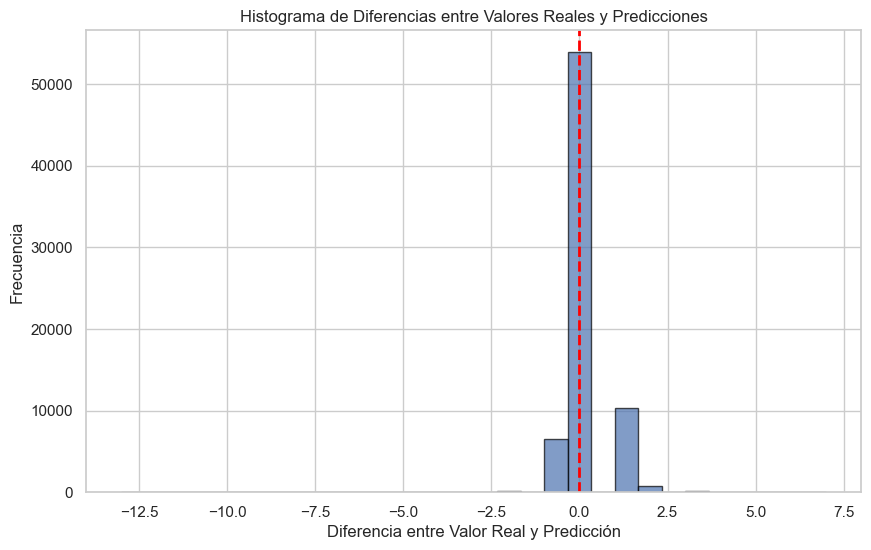

In [67]:
diferencias = test_filtered['y'] - test_filtered['y_pred_rounded']

# Crear un histograma de las diferencias
plt.figure(figsize=(10, 6))
plt.hist(diferencias, bins=30, edgecolor='black', alpha=0.7)

# Añadir títulos y etiquetas
plt.title('Histograma de Diferencias entre Valores Reales y Predicciones')
plt.xlabel('Diferencia entre Valor Real y Predicción')
plt.ylabel('Frecuencia')

# Mostrar línea en diferencia = 0 para referencia
plt.axvline(x=0, color='red', linestyle='--', linewidth=2)

# Mostrar el gráfico
plt.show()